In [1]:
#test the model class on JSWT simulations 
import numpy as np
import pandas as pd
#import splat
#import popsims
from astropy.coordinates import SkyCoord, Galactic
#from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 


from popsims.simulator import Population
from popsims.galaxy import Disk, Halo
from popsims.relations import polynomial_relation
import splat.empirical as spe
import warnings
warnings.filterwarnings("ignore")



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
#SDSS 
SDSS={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

SDSS_discrete={'FOV': 2.5*u.degree*2.5*u.degree,\
      'l':((np.array([0, 360]))*u.degree.to(u.radian)),\
            'b': ((np.array([-90, 90]))*u.degree.to(u.radian))}

In [3]:
DATA_FOLDER='/volumes/Lacie/popsimsdata//'

In [4]:
import astropy.table as astrotable
from astropy.io.votable import parse_single_table

In [5]:
import glob

In [6]:
#forget about sdss use
ffolder='/users/caganze/research/lodieu/*.xml'
lodieu_dfs=[]
for f in glob.glob(ffolder):
    tbl = parse_single_table(f).to_table()
    print('Number of candidates',len(tbl))
    lodieu_dfs.append(tbl.to_pandas())
dfl_conct=pd.concat(lodieu_dfs)

Number of candidates 130
Number of candidates 4
Number of candidates 114
Number of candidates 59
Number of candidates 52
Number of candidates 174
Number of candidates 17
Number of candidates 115
Number of candidates 13
Number of candidates 445
Number of candidates 2
Number of candidates 253


In [7]:
#combine 
ras0=np.nanmedian([dfl_conct['RAJ2000_VHS'].values, dfl_conct['RAJ2000_LAS'].values], axis=0)
decs0=np.nanmedian([dfl_conct['DEJ2000_VHS'].values, dfl_conct['DEJ2000_LAS'].values], axis=0)

In [8]:
assert len(popsims.dropnans(ras0)) == len(dfl_conct)
assert len(popsims.dropnans(decs0)) == len(dfl_conct)

In [9]:
#choose 100 random sightlines
sights= np.random.choice(range(len(ras0)), 50)

In [10]:
footprint=SkyCoord(ra=ras0*u.degree, dec=decs0*u.degree)

In [11]:
len(footprint)

1378

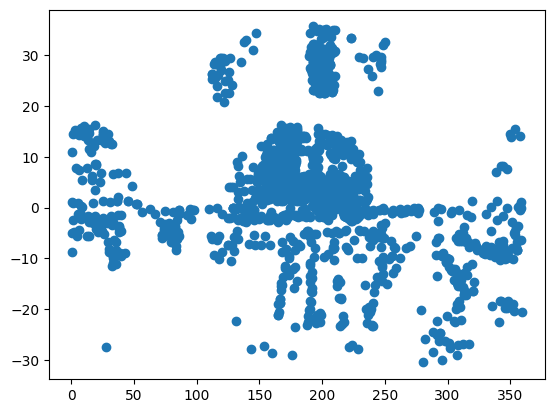

In [12]:
fig, ax=plt.subplots()
ax.scatter(ras0, decs0)

In [13]:
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1, xerr=0.0)
    return np.random.normal(vals, unc)

def get_best2018_relation(spt, flt):
    return spe.typeToMag(spt, flt, ref='best2018')

def get_ps1_mags(df):
    gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    rs=compute_mags_from_reference(df.spt, 'r_ps1', 'freeser2022')
    imags=compute_mags_from_reference(df.spt, 'i_ps1', 'freeser2022')
    zs=compute_mags_from_reference(df.spt, 'z_ps1', 'freeser2022')
    ys=compute_mags_from_reference(df.spt, 'y_ps1', 'freeser2022')
    
    #use beset et al for <16
    best_gs= get_best2018_relation(df.spt, 'PANSTARRS_G')
    best_rs= get_best2018_relation(df.spt, 'PANSTARRS_R')
    best_is= get_best2018_relation(df.spt, 'PANSTARRS_I')
    best_zs= get_best2018_relation(df.spt, 'PANSTARRS_Z')
    best_ys= get_best2018_relation(df.spt, 'PANSTARRS_Y')

    #mask
    mask= df['spt']<=20

    for m, ml in zip([gs, rs, imags, zs, ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
       
    for m, ml in zip([best_gs, best_rs, best_is, best_zs, best_ys], ['G', 'R', 'I', 'Z', 'Y']):
        df['abs_PANSTARRS_{}'.format(ml)]=np.random.normal(m[0], m[1])
        df['PANSTARRS_{}'.format(ml)]=   df['abs_PANSTARRS_{}'.format(ml)]+5*np.log10(df.distance/10.0)
        
    return df

In [14]:
sim_dat= np.load('../simulations.npy', allow_pickle=True).flatten()[0]

In [15]:
#footprint.galactic.l.radian
ukidss_sdss0= sim_dat['ukidss_sdss']
vhs_sdss= sim_dat['vhs_sdss']
vhs_ps= sim_dat['vhs_ps']

In [16]:
#run a combined ukidss-sdss 
#ukidss_sdss0= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
#                             'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K'], \
#                             {'UKIDSS_Y': 20.3, 'UKIDSS_J': 19.9})
#Y=20.3,J=19.9,H=18.6,K=18.2
#G=23.15

In [34]:
def apply_other_cuts_ukidss(t):
    #additional cuts 
    #HJ > -0.9375*(I-J)+ 19.59375
    #J-K <= 0.125*(I-J)+ 0.4875
    #additional cuts
    # HJ >=  −2.14848* (z-J)+ 20.36963
    # J-K <= 0.2963 *(z-J)+ 0.374
    mask0= t.redH_UKIDSS_J > -0.9375*(t.SDSS_I-t.UKIDSS_J)+19.59375
    mask1= (t.UKIDSS_J-t.UKIDSS_K) <= 0.125*(t.SDSS_I-t.UKIDSS_J)+0.4875
    mask2= t.redH_UKIDSS_J > -2.14848*(t.SDSS_Z-t.UKIDSS_J)+20.36963
    mask3= (t.UKIDSS_J-t.UKIDSS_K)<=  0.2963*(t.SDSS_Z-t.UKIDSS_J)+0.374
    
    t=t[np.logical_and.reduce([mask0, mask1, mask2, mask2])]

    return t

ukidss_sdss_r= apply_other_cuts_ukidss(ukidss_sdss0)

In [35]:
len(ukidss_sdss_r), len(ukidss_sdss0)

(392172, 614585)

In [36]:
#add sdss g mag cut
ukidss_sdss=ukidss_sdss_r.query('UKIDSS_Y < 20.3 and UKIDSS_J <19.9 and UKIDSS_H < 18.6 and UKIDSS_K < 18.2  and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5 ' )

In [38]:
len(ukidss_sdss)

2312

In [39]:
#run a combined ukidss-sdss 
#vhs_sdss= simulate_survey(['SDSS_G', 'SDSS_R','SDSS_I', 'SDSS_Z', 
#                             'VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
#                             {'SDSS_G': 23.15})
#Y=20.3,J=19.9,H=18.6,K=18.2

In [22]:
#vhs_ps1=  simulate_survey(['VISTA_Y', 'VISTA_J', 'VISTA_H', 'VISTA_KS'], \
#                             {'VISTA_J': 19.5})

In [40]:
ukidss_sdss_thin=ukidss_sdss_r.query('population == "thin disk"').reset_index(drop=True)
ukidss_sdss_thick=ukidss_sdss_r.query('population == "thick disk"').reset_index(drop=True)
ukidss_sdss_halo=ukidss_sdss_r.query('population =="halo"').reset_index(drop=True)

In [107]:
colors=['#AAAAAA', '#FF851B', '#0074D9']
pops=[ukidss_sdss_thin, ukidss_sdss_thick, ukidss_sdss_halo]
names=['thin disk', 'thick disk', 'halo']
sizes=[20, 30, 30]
markers=['s', '+', '*']

In [93]:
#u=22.0, g=22.2, r=22.2, i=21.3, z=20.5
vhs_sdss=vhs_sdss.query('VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9 and \
SDSS_G < 22.2 and SDSS_R < 22.2 and SDSS_I < 21.3 and SDSS_Z< 20.5')

In [26]:
vhs_ps1=vhs_ps1.query('PANSTARRS_G < 23.3 and PANSTARRS_R < 23.2 and PANSTARRS_I < 23.1 \
and PANSTARRS_Z < 22.3 and PANSTARRS_Y < 21 and VISTA_J < 19.5 and VISTA_H < 18.6 and VISTA_KS < 17.9')

In [43]:
len(ukidss_sdss), len(ukidss_sdss0), len(ukidss_sdss_r)

(2312, 614585, 392172)

[None]

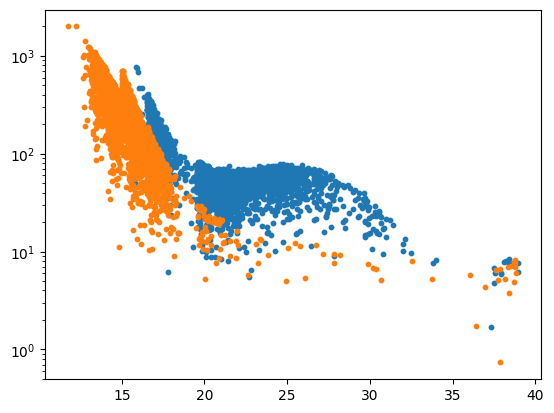

In [110]:
fig, ax=plt.subplots()

#ax.scatter(vhs_ps.spt, vhs_ps.distance, s=0.1)
ax.scatter(ukidss_sdss.spt, ukidss_sdss.distance, s=10)
ax.scatter(vhs_sdss.spt, vhs_sdss.distance, s=10)
ax.set(yscale='log')


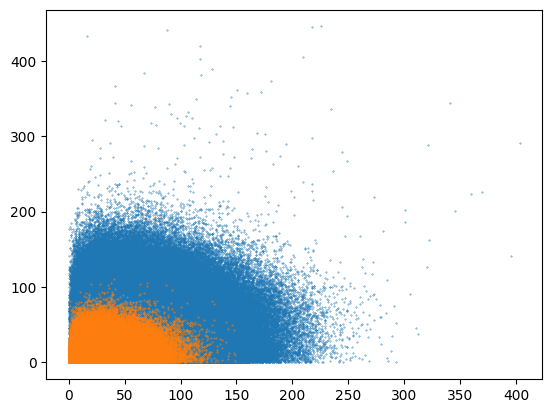

In [77]:
fig, ax=plt.subplots()
mask= vhs_ps.population=='thin disk'


ax.scatter(((vhs_ps.U**2+vhs_ps.W**2)**0.5)[~mask], np.abs(vhs_ps.V[~mask]), s=0.1)
ax.scatter(((vhs_ps.U**2+vhs_ps.W**2)**0.5)[mask], np.abs(vhs_ps.V[mask]), s=0.1)



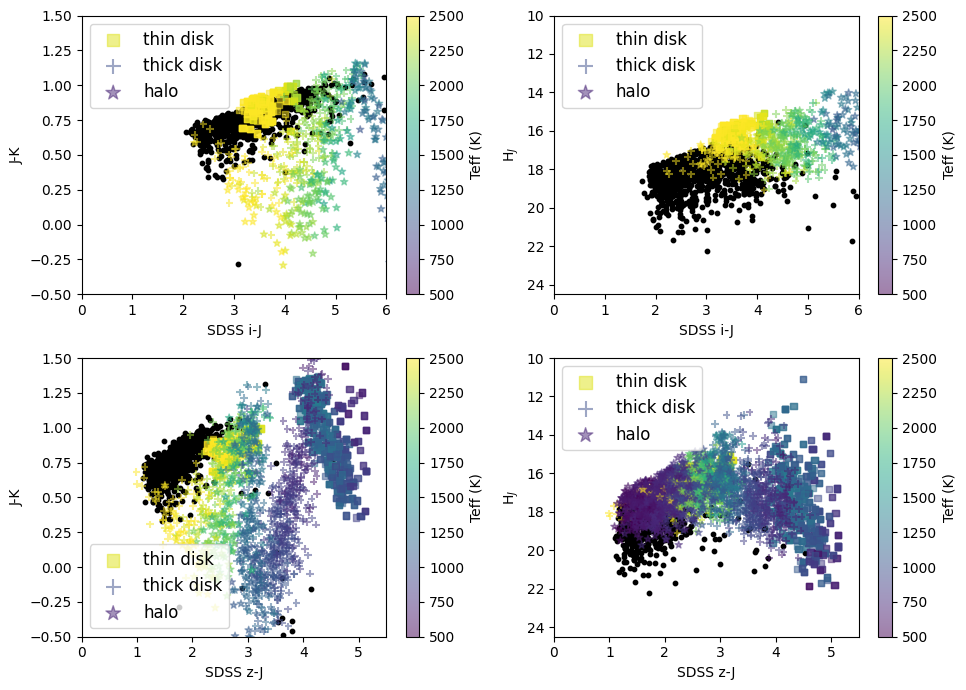

In [120]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(14*0.7, 10*0.7))

ax[0][0].scatter(dfl_conct.SDSSi-dfl_conct.Hmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[0][1].scatter(dfl_conct.SDSSi-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k'  )

ax[1][0].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Jmag_LAS-dfl_conct.Kmag_LAS, s=10, c='k' )
ax[1][1].scatter(dfl_conct.SDSSz-dfl_conct.Jmag_LAS, dfl_conct.Hj, s=10, c='k' )


for idx in range(0, 3):
    p= pops[idx].sample(n=1000, replace=True)
    c=colors[idx]
    n=names[idx]
    s=sizes[idx]
    m= markers[idx]

    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, color=c, ax=ax[0][0])
    ax[0][0].scatter(p.SDSS_I-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, c=p.temperature, \
                     s=s, marker=m, label=n, alpha=0.5, vmin=500, vmax=2500)

    
    #sns.scatterplot(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,color=c, ax=ax[0][1])
    ax[0][1].scatter(p.SDSS_I-p.UKIDSS_J, p.redH_UKIDSS_H,c=p.temperature, s=s, marker=m, label=n,  \
                     alpha=0.5, vmin=500, vmax=2500)

  
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K, ax=ax[1][0], color=c)
    ax[1][0].scatter(p.SDSS_Z-p.UKIDSS_J, p.UKIDSS_J-p.UKIDSS_K,  c=p.temperature, s=s, label=n,
                     marker=m, alpha=0.5, vmin=500, vmax=2500)
    
    #sns.scatterplot(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, color=c, ax=ax[1][1])
    c=ax[1][1].scatter(p.SDSS_Z-p.UKIDSS_J, p.redH_UKIDSS_H, c=p.temperature, s=s, marker=m, label=n,\
                     alpha=0.5, vmin=500, vmax=2500)







for a in np.concatenate(ax):
    l=a.legend(fontsize=12, markerscale=2)
    plt.colorbar(c, ax=a, label='Teff (K)')
ax[0][0].set(xlabel='SDSS i-J', ylabel='J-K', xlim=[0, 6], ylim=[-0.5, 1.5])
ax[0][1].set(xlabel='SDSS i-J', ylabel=r'H$_J$',  xlim=[0, 6], ylim=[10, 24.5])
ax[0][1].invert_yaxis()

ax[1][0].set(xlabel='SDSS z-J', ylabel='J-K', xlim=[0, 5.5], ylim=[-0.5, 1.5])
ax[1][1].set(xlabel='SDSS z-J', ylabel=r'H$_J$', xlim=[0, 5.5], ylim=[10, 24.5])
ax[1][1].invert_yaxis()


plt.tight_layout()

plt.savefig('../figures/plot_simulatedcolors_sdss_ukidss.jpeg')


In [30]:
##can do three selections and color them by temperature?

In [84]:
res_ukidss_sdss={'thin_disk': None, 
                'thick_disk': None,
                'halo': None}

In [85]:
sptgrid=np.arange(10, 40)
res_ukidss_sdss=popsims.compute_vols_and_numbers(ukidss_sdss, Disk(), sptgrid, footprint, {'UKIDSS_J': [14, 20]})
res_vhs_sdss=compute_vols_and_numbers(vhs_sdss, sptgrid, footprint, {'VISTA_Y': [14, 20]})

res_vhs_ps1=compute_vols_and_numbers(vhs_ps1, sptgrid, footprint, {'VISTA_Y': [14, 20]})

NameError: name 'compute_vols_and_numbers' is not defined

In [111]:
res_ukidss_sdss

(          volume
 10  1.091206e+09
 11  8.864681e+08
 12  6.149961e+08
 13  3.941255e+08
 14  2.451867e+08
 15  1.475012e+08
 16  8.357515e+07
 17  4.446536e+07
 18  2.289340e+07
 19  1.190956e+07
 20  6.503210e+06
 21  3.825112e+06
 22  2.455705e+06
 23  1.725052e+06
 24  1.318227e+06
 25  1.082809e+06
 26  9.407168e+05
 27  8.482786e+05
 28  7.781686e+05
 29  7.117446e+05
 30  6.367732e+05
 31  5.477717e+05
 32  4.466430e+05
 33  3.416066e+05
 34  2.437211e+05
 35  1.623054e+05
 36  1.017141e+05
 37  6.101479e+04
 38  3.600105e+04
 39  2.171506e+04,
       number
 10  0.000000
 11  0.000000
 12  0.000000
 13  0.000000
 14  0.000000
 15  0.000000
 16  0.000022
 17  0.000639
 18  0.001727
 19  0.001984
 20  0.003252
 21  0.005623
 22  0.007361
 23  0.008613
 24  0.009733
 25  0.010744
 26  0.011487
 27  0.011919
 28  0.012187
 29  0.012269
 30  0.012411
 31  0.012526
 32  0.012542
 33  0.012558
 34  0.012569
 35  0.012569
 36  0.012569
 37  0.012569
 38  0.012602
 39  0.012635,
 {10: 

In [ ]:
#comon area according to the paper 3667, 1681 and 7692 square degrees fo
# UKIDSS-SDSS, VHS-SDSS and VHS-PS, respectively 
AREA_UKIDSS_SDSS=3667*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_SDSS=1681*(u.degree**2).to(u.radian**2)*(u.radian**2)
AREA_VHS_PS1=7692*(u.degree**2).to(u.radian**2)*(u.radian**2)

AttributeError: 'DataFrame' object has no attribute 'thin'

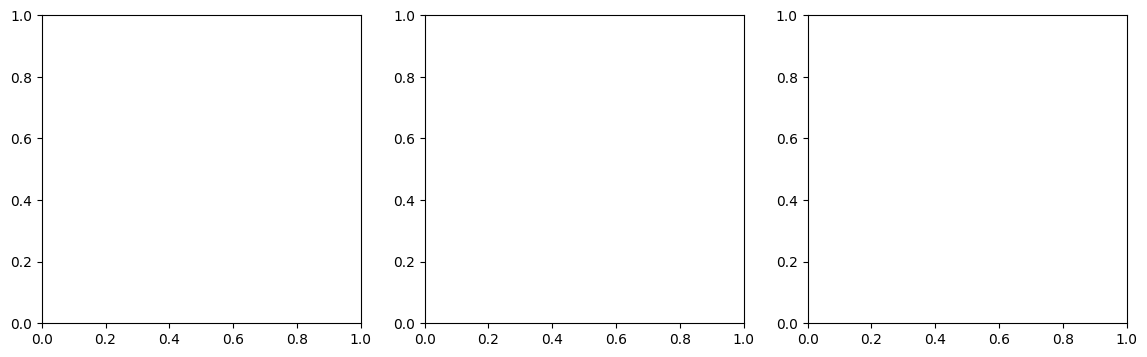

In [121]:
fig, ax=plt.subplots(figsize=(14, 4), ncols=3)

ax[0].step(res_ukidss_sdss[0].index, res_ukidss_sdss[0].thin*res_ukidss_sdss[1].thin*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[0].step(res_ukidss_sdss[0].index, 0.12*res_ukidss_sdss[0].thick*res_ukidss_sdss[1].thick*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[0].step(res_ukidss_sdss[0].index, 0.0025*res_ukidss_sdss[0].halo*res_ukidss_sdss[1].thick*AREA_UKIDSS_SDSS/AREA_UKIDSS_SDSS.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')

ax[1].step(res_vhs_sdss[0].index, res_vhs_sdss[0].thin*res_vhs_sdss[1].thin*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[1].step(res_vhs_sdss[0].index, 0.12*res_vhs_sdss[0].thick*res_vhs_sdss[1].thick*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[1].step(res_vhs_sdss[0].index, 0.0025*res_vhs_sdss[0].halo*res_vhs_sdss[1].thick*AREA_VHS_SDSS/AREA_VHS_SDSS.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')


ax[-1].step(res_vhs_ps1[0].index, res_vhs_ps1[0].thin*res_vhs_ps1[1].thin*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2),\
        color=colors[0],  linestyle='dotted', label='Thin Disk')
ax[-1].step(res_vhs_ps1[0].index, 0.12*res_vhs_ps1[0].thick*res_vhs_ps1[1].thick*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2), \
        color=colors[1], linestyle='--', label='Thick Disk')
ax[-1].step(res_vhs_ps1[0].index, 0.0025*res_vhs_ps1[0].halo*res_vhs_ps1[1].thick*AREA_VHS_PS1/AREA_VHS_PS1.to(u.degree**2), \
        color=colors[-1], linestyle='-',  label='Halo')




ax[0].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='UKIDSS-SDSS')

ax[1].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='VHS-SDSS')

ax[-1].set(yscale='log', ylabel=r'Surface Density (deg $^{-2})$',\
       xlabel='Spectral Type', title='VHS-PS1')



for a in ax:
    a.legend(fontsize=10, loc='upper right')
    a.set(yscale='log')
    
ax[0].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])
ax[1].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])
ax[-1].set(xticks=[10, 15,20, 25], xticklabels=['M0', 'M5', 'L0', 'L5'])



plt.tight_layout()
plt.savefig('../figures/plot_simulatedncounts.pdf')